In [1]:
import symforce

symforce.set_epsilon_to_symbol()
# https://github.com/symforce-org/symforce/issues/299
# https://github.com/symforce-org/symforce/issues/300
# https://colab.research.google.com/drive/11G80afyuW_Wxse4o4-Nikb8syi38Mjlk?usp=sharing#scrollTo=Xn3SeYzyRCTL


In [2]:
# -----------------------------------------------------------------------------
# Load the .g2o file
# -----------------------------------------------------------------------------
import numpy as np

from symforce import typing as T
from symforce.values import Values


In [3]:
import symforce.symbolic as sf
from symforce import logger


In [4]:
def info2mat(info):
    '''This function returns a 6x6 information matrix'''
    mat = np.zeros((6, 6))
    ix = 0
    for i in range(mat.shape[0]):
        mat[i, i:] = info[ix : ix + (6 - i)]
        mat[i:, i] = info[ix : ix + (6 - i)]
        ix += 6 - i
    return mat


In [5]:
def printData(filename_path: str):
    with open(filename_path) as f:
        for line in f:
            line = line.split()
            # print(line)
            if line[0] == "VERTEX_SE3:QUAT":
                # ids.append(sf.Scalar(int(line[1])))
                # nodes.append(sf.Pose3(R = sf.Rot3(
                #                 sf.Quaternion(xyz= np.array(line[5:-1], dtype=np.float64), w = float(line[-1]))),
                #                 t = sf.Vector3(np.array(line[2:5], dtype=np.float64))))
                # pass
                print(line)
            elif line[0] == "EDGE_SE3:QUAT":
                # edges.append(sf.Vector2(np.array(line[1:3], dtype=np.int64)))
                # poses.append(sf.Pose3(R = sf.Rot3(
                #                 sf.Quaternion(xyz= np.array(line[6:9], dtype=np.float64), w = float(line[9]))),
                #                 t = sf.Vector3(np.array(line[3:6], dtype=np.float64))))
                # infos.append()
                print(line)


# printData("/home/vrex/symForce/symforce_ws/pose_graph_opt/data/parking-garage.g2o")


In [6]:
def build_values(filename_path: str) -> T.Tuple[Values, int]:
    # np.random.seed(42)

    # Create a problem setup and initial guess

    ids = []
    poses = []
    nodes = []
    edges = []
    infos = []
    with open(filename_path) as f:
        for line in f:
            line = line.split()
            if line[0] == "VERTEX_SE3:QUAT":
                ids.append(sf.Scalar(int(line[1])))
                nodes.append(
                    sf.Pose3(
                        R=sf.Rot3(
                            sf.Quaternion(
                                xyz=np.array(line[5:-1], dtype=np.float64),
                                w=float(line[-1]),
                            )
                        ),
                        t=sf.Vector3(np.array(line[2:5], dtype=np.float64)),
                    )
                )

            elif line[0] == "EDGE_SE3:QUAT":
                edges.append(sf.Vector2(np.array(line[1:3], dtype=np.int64)))
                poses.append(
                    sf.Pose3(
                        R=sf.Rot3(
                            sf.Quaternion(
                                xyz=np.array(line[6:9], dtype=np.float64),
                                w=float(line[9]),
                            )
                        ),
                        t=sf.Vector3(np.array(line[3:6], dtype=np.float64)),
                    )
                )
                infos.append(
                    sf.Matrix66(info2mat(np.array(line[10:], dtype=np.float64)))
                )

    initial_values = Values(
        ids = ids,
        poses = poses,
        posePrior = sf.Pose3(),
        nodes = nodes,
        edges = edges,
        infos = infos,
        epsilon = sf.numeric_epsilon
    )

    # max_val = -np.Inf
    # for i in range(len(edges)):
    #     # max_val = max((edges[i][1] - edges[i][0]), max_val)
    #     if (edges[i][1] - edges[i][0]) > max_val:
    #         max_val = (edges[i][1] - edges[i][0])
    #         print(max_val)
    # print(max_val)
    
    # values["ids"] = np.stack(ids)
    # values["poses"] = np.stack(poses)
    # values["nodes"] = np.stack(nodes)
    # values["edges"] = np.stack(edges)
    # values["infos"] = np.stack(infos)

    # values["epsilon"] = sf.numeric_epsilon

    # print("num ids",values["ids"])
    # print("num poses",values["poses"])
    # print("num nodes",values["nodes"])
    # print("num edges", values["edges"])
    # print("num infos",values["infos"])
    # print('infos',infos[0] )
    # print('infos',values["infos"][0] )
    # return values, values["nodes"].shape[0]

    return initial_values, len(nodes)


In [7]:
# Testingn whether the dat loads properly or not
# val, num = build_values(
#     "/home/vrex/symForce/symforce_ws/pose_graph_opt/data/parking-garage.g2o"
# )
# #
# # TODO test more thoroughly
# display(val["poses[0]"])
# print(num)


In [8]:
def pose_prior_residual(
        pose0: sf.Pose3,
        posePrior: sf.Pose3,
        epsilon: sf.Scalar
    ) -> sf.V6:
    return sf.V6(pose0.local_coordinates(posePrior, epsilon=epsilon))

def odometry_residual(
    world_T_a: sf.Pose3,
    world_T_b: sf.Pose3,
    a_T_b: sf.Pose3,
    infos_m: sf.Matrix66,
    epsilon: sf.Scalar,
) -> sf.V6:
    a_T_b_predicted = world_T_a.inverse() * world_T_b
    # Find the relative error between a_T_b and a_T_b_predicted in tangent space
    tangent_error = a_T_b_predicted.local_coordinates(a_T_b, epsilon=epsilon)

    return T.cast(sf.V6, (infos_m).inv() * sf.V6(tangent_error)) 


In [9]:
from symforce.opt.factor import Factor


def build_factors(num_nodes: int, values: Values) -> T.Iterator[Factor]:
    """
    Build factors for a problem of the given dimensionality.

    TODO: this looks wrong -> figure it out


    """
    
    for i in range(num_nodes):
        node0_idx = values["edges"][i][0]
        node1_idx = values["edges"][i][1]
        yield Factor(
            residual=odometry_residual,
            keys=[
                #   f"nodes[edges[{i}][0]]",
                #   f"nodes[edges[{i}][1]]",
                f"nodes[{node0_idx}]",
                f"nodes[{node1_idx}]",
                f"poses[{i}]",
                f"infos[{i}]",
                "epsilon",
            ],
        )

    # # Prior factor
    # yield Factor(
    #     residual=pose_prior_residual,
    #     keys=[f"nodes[{i}]", "posePrior", "epsilon"]
    # )


In [10]:
from symforce.opt.optimizer import Optimizer

_values, _num_nodes = build_values(
    "/home/vrex/symForce/symforce_ws/pose_graph_opt/data/parking-garage.g2o"
)


In [11]:
# Create factors
factors = build_factors(num_nodes=_num_nodes, values = _values)


In [12]:
# Select the keys to optimize - the rest will be held constant
_optimized_keys = [f"nodes[{i}]" for i in range( _num_nodes)]

In [13]:
# Create the optimizer
optimizer = Optimizer(
    factors=factors,
    optimized_keys=_optimized_keys,
    debug_stats=True,  # Return problem stats for every iteration
    params=Optimizer.Params(verbose=True),  # Customize optimizer behavior
    # params=Optimizer.Params(verbose=True, iterations=200),
)


In [14]:
# Solve and return the result
result = optimizer.optimize(_values)


[2023-04-05 02:36:56.168] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 9986444786.832/0.000/16240764.000, rel reduction: 0.99837
[2023-04-05 02:37:00.966] [info] LM<sym::Optimize> [iter    1] lambda: 2.500e-01, error prev/linear/new: 16240764.402/0.000/3399017.250, rel reduction: 0.79071
[2023-04-05 02:37:05.401] [info] LM<sym::Optimize> [iter    2] lambda: 6.250e-02, error prev/linear/new: 3399017.262/0.000/1467135.500, rel reduction: 0.56836
[2023-04-05 02:37:10.324] [info] LM<sym::Optimize> [iter    3] lambda: 1.562e-02, error prev/linear/new: 1467135.448/0.000/467240.125, rel reduction: 0.68153
[2023-04-05 02:37:14.924] [info] LM<sym::Optimize> [iter    4] lambda: 3.906e-03, error prev/linear/new: 467240.132/0.000/7457203.000, rel reduction: -14.96011
[2023-04-05 02:37:19.518] [info] LM<sym::Optimize> [iter    5] lambda: 1.562e-02, error prev/linear/new: 467240.132/0.000/3844259.500, rel reduction: -7.22759
[2023-04-05 02:37:24.209] [info] LM<sym::

In [15]:
# Print some values
print(f"Num iterations: {len(result.iteration_stats) - 1}")
print(f"Final error: {result.error():.6f}")


Num iterations: 50
Final error: 5.403295


In [16]:
import matplotlib.pyplot as plt
def plot_nodes(nodes, ax, color="-r", label=""):
    x, y, z = [], [], []
    for n in nodes:
        x.append(n.t.x)
        y.append(n.t.y)
        z.append(n.t.z)
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)
    max_range = (
        np.array([x.max() - x.min(), y.max() - y.min(), z.max() - z.min()]).max() / 2.0
    )
    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    ax.plot(x, y, z, color)
    # ax.legend(str(label))

def plot_symforce_result(nodes, ax, color="-r", label=""):
    x, y, z = [], [], []
    for n in nodes:
        x.append(n.t[0])
        y.append(n.t[1])
        z.append(n.t[2])
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    z = np.asarray(z, dtype=float)
    max_range = (
        np.array([x.max() - x.min(), y.max() - y.min(), z.max() - z.min()]).max() / 2.0
    )
    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)
    ax.plot(x, y, z, color)
    # ax.legend(str(label))


In [17]:
initial_values, ini_num_nodes = build_values(
    "/home/vrex/symForce/symforce_ws/pose_graph_opt/data/parking-garage.g2o"
)


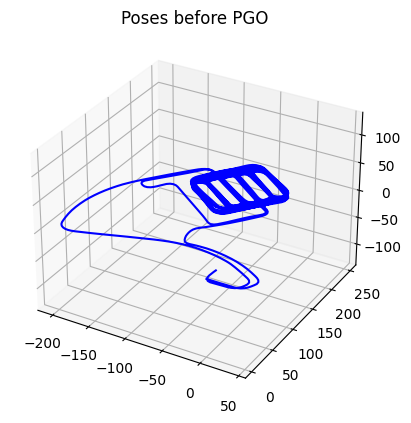

In [18]:
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection="3d")
# plt.cla()
plt.title("Poses before PGO")
plot_nodes(initial_values["nodes"], ax, color="-b", label=str("before"))
# plot_symforce_result(result.optimized_values["nodes"], ax, label="after")
plt.show()

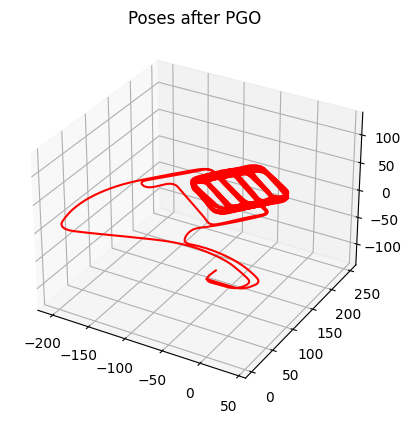

In [19]:
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection="3d")
# plt.cla()
# plot_nodes(initial_values["nodes"], ax, color="-b", label="before")
plt.title("Poses after PGO")
plot_symforce_result(result.optimized_values["nodes"], ax, label="after")
plt.show()


In [20]:
def plot_correction_applied(ini_nodes, final_nodes, ax, color="-r", label=""):
    x_ini, y_ini, z_ini = [], [], []
    for n in ini_nodes:
        x_ini.append(n.t.x)
        y_ini.append(n.t.y)
        z_ini.append(n.t.z)
    
    x_fin, y_fin, z_fin = [], [], [] 
    for n in final_nodes:
        x_fin.append(n.t[0])
        y_fin.append(n.t[1])
        z_fin.append(n.t[2])
    x_ini = np.asarray(x_ini, dtype=float)
    y_ini = np.asarray(y_ini, dtype=float)
    z_ini = np.asarray(z_ini, dtype=float)

    x_fin = np.asarray(x_fin, dtype=float)
    y_fin = np.asarray(y_fin, dtype=float)
    z_fin = np.asarray(z_fin, dtype=float)

    ax[0].plot(x_ini - x_fin, marker='o', linestyle='none', color = 'r')
    ax[0].set_ylabel('correction')
    ax[0].set_xlabel('X-axis')

    ax[1].plot(y_ini - y_fin, marker='o', linestyle='none', color = 'b')
    ax[1].set_ylabel('correction')
    ax[1].set_xlabel('Y-axis')

    ax[2].plot(z_ini - z_fin, marker='o', linestyle='none', color = 'k')
    ax[2].set_ylabel('correction')
    ax[2].set_xlabel('Z-axis')

<Figure size 640x480 with 0 Axes>

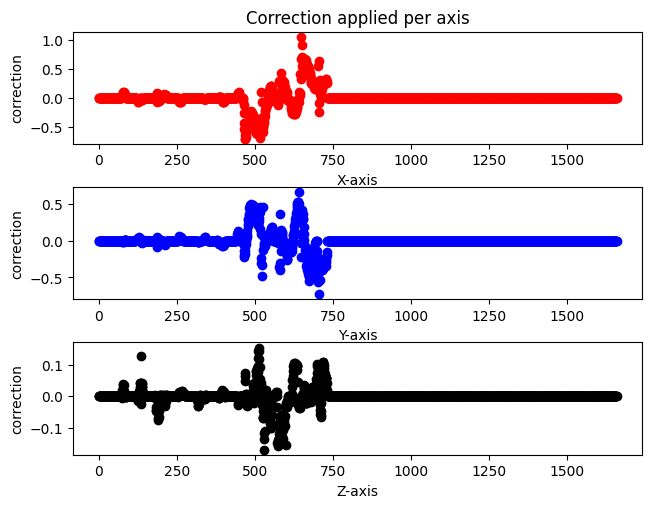

In [21]:
est_traj_fig = plt.figure()
# ax = est_traj_fig.add_subplot(111, projection="3d")
fig, axes = plt.subplots(nrows=3)
fig.tight_layout(pad=1.0)
axes[0].set_title("Correction applied per axis")

# plt.cla()
plot_correction_applied(initial_values["nodes"], result.optimized_values["nodes"], axes )
plt.show()